In [4]:
import numpy as np
import scipy.optimize as optim
import scipy.interpolate as polate

def CDS_bootstrap(cds_spreads, yield_curve, cds_tenor, yield_tenor, prem_per_year, R):
    '''
    Bootstraps a credit curve from CDS spreads of varying maturities. Returns the hazard 
    rate values and survival probabilities corresponding to the CDS maturities.

    Args:
        cds_spreads :   vector of CDS spreads
        yield_curve :   vector of risk-free bond yields
        cds_tenor :     vector of maturities corresponding to the given CDS spreads
        yield_tenor :   vector of risk-free bond yield tenor matching yield_curve
        prem_per_year : premiums paid per year on the CDS (i.e. annualy=1, semiannually=2, quarterly=4, monthly=12) 
        R :             recovery rate
    '''

    # Checks
    if len(cds_spreads) != len(cds_tenor):
        print("CDS spread array does match CDS tenor array.")
        return None

    if len(yield_curve) != len(yield_tenor):
        print("Yield curve array does not match yield tenor.")
        return None
    
    # Interpolation/Extrapolation function  
    interp = polate.interp1d(yield_tenor, yield_curve,'linear', fill_value='extrapolate')
    
    # The bootstrap function
    def bootstrap(h, given_haz, s, cds_tenor, yield_curve, prem_per_year, R):
        '''
        Returns the difference between values of payment leg and default leg.
        '''
        a = 1/prem_per_year
        maturities = [0] + list(cds_tenor)    
        pmnt = 0;        dflt = 0;        auc = 0
        
        # 1. Calculate value of payments for given hazard rate curve values
        for i in range(1, len(maturities)-1):
            num_points = int((maturities[i]-maturities[i-1])*prem_per_year + 1)
            t = np.linspace(maturities[i-1], maturities[i], num_points) 
            r = interp(t)
            
            for j in range(1, len(t)):
                surv_prob_prev = np.exp(-given_haz[i-1]*(t[j-1]-t[0]) - auc)
                surv_prob_curr = np.exp(-given_haz[i-1]*(t[j]-t[0]) - auc)
                pmnt += s*a*np.exp(-r[j]*t[j])*0.5*(surv_prob_prev + surv_prob_curr)
                dflt += np.exp(-r[j]*t[j])*(1-R)*(surv_prob_prev - surv_prob_curr)
        
            auc += (t[-1] - t[0])*given_haz[i-1]
        
        # 2. Set up calculations for payments with the unknown hazard rate value
        num_points = int((maturities[-1]-maturities[-2])*prem_per_year + 1)
        t = np.linspace(maturities[-2], maturities[-1], num_points)
        r = interp(t)
        
        for i in range(1, len(t)):
            surv_prob_prev = np.exp(-h*(t[i-1]-t[0]) - auc)
            surv_prob_curr = np.exp(-h*(t[i]-t[0]) - auc)          
            pmnt += s*a*np.exp(-r[i]*t[i])*0.5*(surv_prob_prev + surv_prob_curr)
            dflt += np.exp(-r[i]*t[i])*(1-R)*(surv_prob_prev - surv_prob_curr)
        
        return abs(pmnt-dflt)
    
    haz_rates = []
    surv_prob = []
    t = [0] + list(cds_tenor)
    
    for i in range(len(cds_spreads)):
        get_haz = lambda x: bootstrap(x, haz_rates, cds_spreads[i], cds_tenor[0:i+1], yield_curve[0:i+1], prem_per_year, R)
        haz = round(optim.minimize(get_haz, cds_spreads[i]/(1-R), method='SLSQP', tol = 1e-10).x[0],8)
        cond_surv = (t[i+1]-t[i])*haz
        haz_rates.append(haz)
        surv_prob.append(cond_surv)
    
    return haz_rates, np.exp(-np.cumsum(surv_prob))



def CDS_spread(credit_curve, yield_curve, credit_curve_tenor, yield_tenor, prem_per_year, R, maturity):
    '''
    Returns the spread of a CDS using a yield curve and credit curve

    Args:
        credit_curve :  vector of hazard rates that correspond to CDSs of different maturities
        yield_curve :   vector of yields for risk-free bonds
        credit_curve_tenor :    vector of maturities for CDS contracts corresponding to credit_curve
        yield_tenor :   vector of risk-free bond yield maturities corresponding to yield_curve
        prem_per_year : number of premiums paid per year (i.e. annually=1, semiannually=2, quarterly=4, monthly=12)
        R :             recovery rate
        maturity :      desired CDS maturity
    '''
    # Checks
    if len(yield_curve) != len(yield_tenor):
        print('Yield curve does not match the yield tenor')
        return None
    
    if len(credit_curve) != len(credit_curve_tenor):
        print('Credit curve does not match the credit curve tenor')
        return None            
    
    # I. Get survival probabilities and default probabilities using hazard rate curve
    a = 1/prem_per_year
    num_points = int(credit_curve_tenor[-1]/a + 1)
    t = np.linspace(0, credit_curve_tenor[-1], num_points)
    h = []
    index = 0;  t_index = credit_curve_tenor[index]
    
    for i in range(len(t)):
        if t[i] <= t_index:
            h.append(credit_curve[index])
        else:
            index += 1
            t_index = credit_curve_tenor[index]
            h.append(credit_curve[index])
        
    surv_prob = [1.0]
    
    for i in range(1,len(t)):
        surv_prob.append(a*h[i])
        
    surv_prob = np.exp(-np.cumsum(surv_prob))    
    default_prob = np.asarray([0] + list(-np.diff(surv_prob)))
    
    # II. Interpolate/Extrapolate yield curve values corresponding to payment times and default times    
    interp = polate.interp1d(yield_tenor, yield_curve, 'linear',fill_value='extrapolate')
    pay_periods = np.linspace(0, credit_curve_tenor[-1], num_points)
    mid_periods = np.linspace(a/2, credit_curve_tenor[-1]-a/2, num_points-1)
    yield1 = interp(pay_periods)
    yield2 = interp(mid_periods)
        
    # III. Solve
    PV_pmnt = [np.exp(-yield1[i]*pay_periods[i])*surv_prob[i] for i in range(1,len(pay_periods))] #This works 
    PV_payoff = [(1-R)*default_prob[i+1]*np.exp(-yield2[i]*mid_periods[i]) for i in range(len(mid_periods))]
    PV_accrual = [np.exp(-yield2[i]*mid_periods[i])*0.5*a*default_prob[i+1] for i in range(len(mid_periods))]
    
    return sum(PV_payoff)/(sum(PV_pmnt) + sum(PV_accrual))



def binary_CDS_spread(credit_curve, yield_curve, credit_curve_tenor, yield_tenor, prem_per_year, default_payout, maturity):
    '''
    Returns the spread of a binary CDS using a yield curve and credit curve

    Args:
        credit_curve :  vector of hazard rates that correspond to CDSs of different maturities
        yield_curve :   vector of yields for risk-free bonds
        credit_curve_tenor :    vector of maturities for CDS contracts corresponding to credit_curve
        yield_tenor :   vector of risk-free bond yield maturities corresponding to yield_curve
        prem_per_year : number of premiums paid per year (i.e. annually=1, semiannually=2, quarterly=4, monthly=12)
        default_payout :    amount paid in the event of a default as % of principal
        maturity :      desired CDS maturity
    '''
    # Checks
    if len(yield_curve) != len(yield_tenor):    
        print('Yield curve does not match the yield tenor')
        return None
    
    if len(credit_curve) != len(credit_curve_tenor):
        print('Credit curve does not match the credit curve tenor')
        return None      
    
    # I. Get survival probabilities and default probabilities using hazard rate curve
    a = 1/prem_per_year
    num_points = int(credit_curve_tenor[-1]/a + 1)
    t = np.linspace(0, credit_curve_tenor[-1], num_points)
    h = []
    index = 0;  t_index = credit_curve_tenor[index]

    for i in range(len(t)):
        if t[i] <= t_index:
            h.append(credit_curve[index])
        else:
            index += 1
            t_index = credit_curve_tenor[index]
            h.append(credit_curve[index])
        
    surv_prob = [1.0]
    
    for i in range(1,len(t)):
        surv_prob.append(a*h[i])
        
    surv_prob = np.exp(-np.cumsum(surv_prob))    
    default_prob = np.asarray([0] + list(-np.diff(surv_prob)))    
    
    # II. Interpolate/Extrapolate yield curve values corresponding to payment times and default times    
    interp = polate.interp1d(yield_tenor, yield_curve, 'linear',fill_value='extrapolate')
    pay_periods = np.linspace(0, credit_curve_tenor[-1], num_points)
    mid_periods = np.linspace(a/2, credit_curve_tenor[-1]-a/2, num_points-1)
    yield1 = interp(pay_periods)
    yield2 = interp(mid_periods)
    
    # III. Solve
    PV_pmnt = [np.exp(-yield1[i]*pay_periods[i])*surv_prob[i] for i in range(1,len(pay_periods))]
    PV_payoff = [default_payout*default_prob[i+1]*np.exp(-yield2[i]*mid_periods[i]) for i in range(len(mid_periods))]
    PV_accrual = [np.exp(-yield2[i]*mid_periods[i])*0.5*a*default_prob[i+1] for i in range(len(mid_periods))]
    
    return sum(PV_payoff)/(sum(PV_pmnt) + sum(PV_accrual))



ModuleNotFoundError: No module named 'scipy'

In [ ]:
def calculate_cds_npv(cds_spread, yield_curve, cds_tenor, yield_tenor, prem_per_year, R):
    hazard_rates, surv_probs = CDS_bootstrap(cds_spread, yield_curve, cds_tenor, yield_tenor, prem_per_year, R)
    npv = sum([calculate_cds_premium_leg(h, cds_spread, cds_tenor, yield_curve, prem_per_year, R) -
               calculate_cds_default_leg(h, cds_spread, cds_tenor, yield_curve, prem_per_year, R) for h in hazard_rates])
    return npv
    
def interpolate_yield_curve(t, yield_curve):
    '''
    Helper function to interpolate/extrapolate yield curve values.

    Args:
        t : time points at which interpolation/extrapolation is needed
        yield_curve : vector of risk-free bond yields

    Returns:
        interpolated/extrapolated yields corresponding to the input time points
    '''
    interp = polate.interp1d(yield_tenor, yield_curve, 'linear', fill_value='extrapolate')
    return interp(t)
    
def calculate_cds_default_leg(hazard_rate, cds_spread, cds_tenor, yield_curve, prem_per_year, R):
    a = 1 / prem_per_year
    maturities = [0] + list(cds_tenor)
    default_leg = 0

    for i in range(1, len(maturities)):
        num_points = int((maturities[i] - maturities[i - 1]) * prem_per_year + 1)
        t = np.linspace(maturities[i - 1], maturities[i], num_points)
        r = interpolate_yield_curve(t, yield_curve)
        accrual = np.exp(-r[0] * t[0]) * 0.5 * a * np.exp(-hazard_rate * (t[-1] - t[0]))
        default_leg += np.exp(-r[-1] * t[-1]) * (1 - R) * (1 - np.exp(-hazard_rate * (t[-1] - t[0]))) + accrual

    return default_leg
    
def calculate_cds_premium_leg(hazard_rate, cds_spread, cds_tenor, yield_curve, prem_per_year, R):
    a = 1 / prem_per_year
    maturities = [0] + list(cds_tenor)
    premium_leg = 0

    for i in range(1, len(maturities)):
        num_points = int((maturities[i] - maturities[i - 1]) * prem_per_year + 1)
        t = np.linspace(maturities[i - 1], maturities[i], num_points)
        r = interpolate_yield_curve(t, yield_curve)

        for j in range(1, len(t)):
            surv_prob_prev = np.exp(-hazard_rate * (t[j - 1] - t[0]))
            surv_prob_curr = np.exp(-hazard_rate * (t[j] - t[0]))
            premium_leg += a * np.exp(-r[j] * t[j]) * 0.5 * (surv_prob_prev + surv_prob_curr)

    return premium_leg
    
def calculate_cds_float_leg(hazard_rate, cds_spread, cds_tenor, yield_curve, prem_per_year, R):
    return calculate_cds_premium_leg(hazard_rate, cds_spread, cds_tenor, yield_curve, prem_per_year, R)
    
def calculate_cds_fixed_leg(hazard_rate, cds_spread, cds_tenor, yield_curve, prem_per_year, R):
    return calculate_cds_default_leg(hazard_rate, cds_spread, cds_tenor, yield_curve, prem_per_year, R)


Hazard Rates: [0.03333642, 0.06808596, -0.03027795]
Survival Probabilities: [0.96721312 0.90355131 0.93132737]
CDS Spread for 2-year maturity: 0.015178330146570636
Binary CDS Spread for 2-year maturity: 0.012648608455475531
CDS NPV: 4.025994835761445


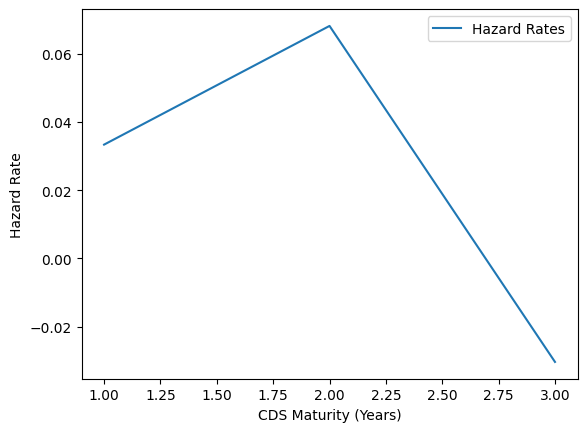

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
cds_spreads = np.array([0.02, 0.03, 0.015])  # CDS spreads
yield_curve = np.array([0.02, 0.025, 0.03])  # Risk-free yield curve
cds_tenor = np.array([1, 2, 3])  # CDS maturities in years
yield_tenor = np.array([1, 2, 3])  # Risk-free yield tenor

prem_per_year = 1  # Premiums paid annually
recovery_rate = 0.4  # Recovery rate

# Example 1: Test CDS_bootstrap
hazard_rates, survival_probs = CDS_bootstrap(cds_spreads, yield_curve, cds_tenor, yield_tenor, prem_per_year, recovery_rate)
print("Hazard Rates:", hazard_rates)
print("Survival Probabilities:", survival_probs)

# Example 2: Test CDS_spread
maturity_to_test = 2
calculated_cds_spread = CDS_spread(hazard_rates, yield_curve, cds_tenor, yield_tenor, prem_per_year, recovery_rate, maturity_to_test)
print(f"CDS Spread for {maturity_to_test}-year maturity: {calculated_cds_spread}")

# Example 3: Test binary_CDS_spread
binary_cds_spread = binary_CDS_spread(hazard_rates, yield_curve, cds_tenor, yield_tenor, prem_per_year, 0.5, maturity_to_test)
print(f"Binary CDS Spread for {maturity_to_test}-year maturity: {binary_cds_spread}")

# Example 4: Test calculate_cds_npv
npv = calculate_cds_npv(cds_spreads, yield_curve, cds_tenor, yield_tenor, prem_per_year, recovery_rate)
print("CDS NPV:", npv)

# Plotting
plt.plot(cds_tenor, hazard_rates, label='Hazard Rates')
plt.xlabel('CDS Maturity (Years)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.show()
